In [167]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [168]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml

from typing import List, Dict, Any, Callable
from pathlib import Path
import seaborn as sns


# local imports
from src.data_processing.preprocessing.pandas_preprocessors import flatten_dataframe
from src.data_processing.model_analyzers.elastic_net_analyzers.elastic_net_analyzer import MetricAnalyzer, FeatureImportanceAnalyzer, ExperimentMetadata
from src.data_processing.model_analyzers.elastic_net_analyzers.path_finder import PathFinder

In [169]:
results_path = Path('/Users/mds8301/Development/ENIGMA/results/experiments/endpoint_experiments/xgb_reg_da_w_action_no_day_norm_tune')
path_finder = PathFinder(results_path)

metric_analyzer = MetricAnalyzer(path_finder.metrics_paths[0], ExperimentMetadata)

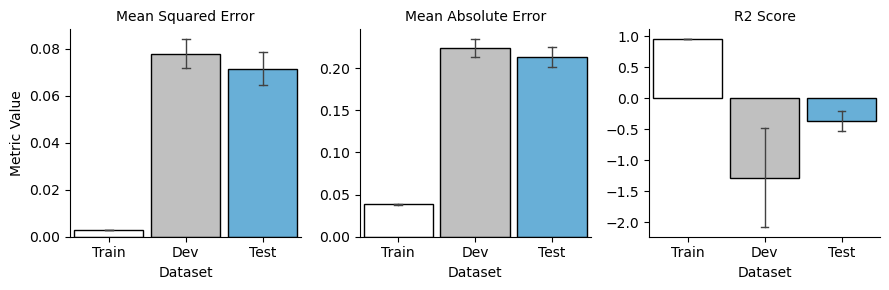

In [170]:
metric_analyzer.read_and_clean_data()
metric_analyzer.plot_data()

/Users/mds8301/Development/ENIGMA/src/data_processing/model_analyzers/elastic_net_analyzers/elastic_net_analyzer.py:231: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance',


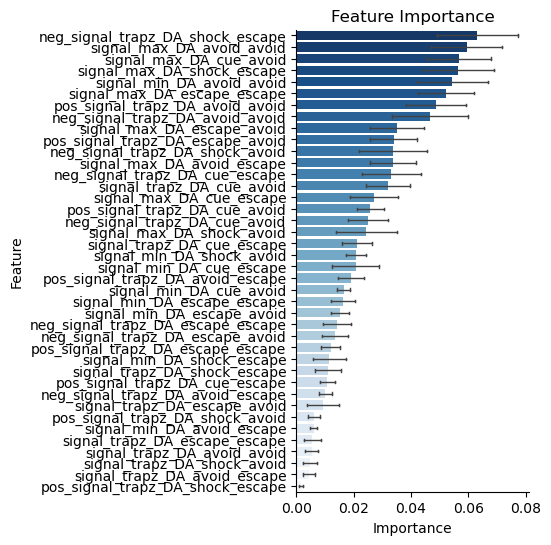

In [171]:
feature_analyzer = FeatureImportanceAnalyzer(path_finder.feature_importance_paths[0], ExperimentMetadata)
feature_analyzer.read_and_clean_data()
feature_analyzer.plot_data()

<Axes: xlabel='true_values', ylabel='predictions'>

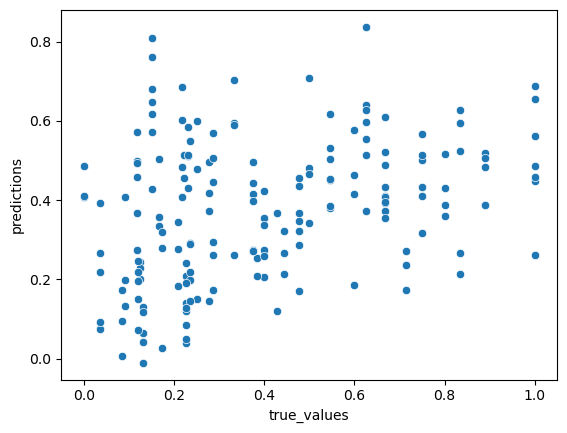

In [172]:
predictions = pd.read_parquet(path_finder.predictions_path[0])
sns.scatterplot(data=predictions, x = 'true_values', y = 'predictions')

In [177]:
params_path = '/Users/mds8301/Development/ENIGMA/results/experiments/endpoint_experiments/xgb_reg_da_w_action_no_day_norm_tune/params.yaml'
import yaml
with open(params_path, 'r') as file:
    params = yaml.safe_load(file)
best_params = params['best_params']

best_params

{'learning_rate': 0.7720296764063289,
 'max_delta_step': 20906.788445572492,
 'max_depth': 1,
 'min_child_weight': 2.6295833299734515,
 'n_estimators': 200,
 'reg_alpha': 0.29273872474498935,
 'reg_lambda': 6.301438723555968,
 'scale_pos_weight': 0.47219619394213225,
 'subsample': 0.6308071418881683}

In [174]:
import xgboost as xgb
from src.data_processing.model_analyzers.xgb_analyzers.XGBRegrResults import XGBRegrResults
from src.data_processing.preprocessing.pandas_preprocessors import xgb_reg_signal_params_only_pd_preprocessor, normalized_preprocessor_wo_day,  normalize_by_baseline
from src.data_processing.pipelines.ClassifierPipe import ClassifierPipe
from functools import partial

raw_data_path = '/Users/mds8301/iterm_data_storage/raw_data_raw_data.parquet.gzip'
df_processor = partial(normalized_preprocessor_wo_day,
                       normalizer=normalize_by_baseline,
                       query="sensor=='DA'",
                       experiment_cols_to_drop=None)

pipeline = (ClassifierPipe(raw_data_path)
            .read_raw_data()
            .pandas_pipe(df_processor)
            .split_by_ratio(target='ratio_avoid', shuffle = True)
            .transform_data()
            )

/Users/mds8301/anaconda3/envs/enigma_xgb/lib/python3.11/site-packages/xgboost/data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


<Axes: xlabel='true_values', ylabel='predictions'>

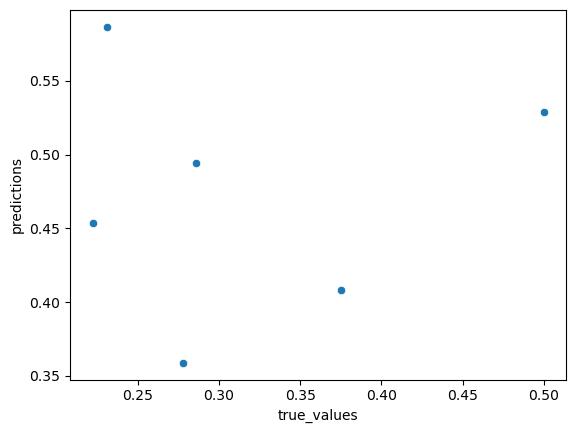

In [182]:

model = xgb.XGBRegressor(objective='reg:squarederror',
                         eval_metric=['rmse', 'mae'],**best_params)
model.fit(pipeline.X_train, pipeline.y_train)
test_predictions = model.predict(pipeline.X_dev)
test_data = pd.DataFrame({'true_values': pipeline.y_dev,
                         'predictions': test_predictions}).reset_index(drop=True)
sns.scatterplot(data=test_data, x='true_values', y='predictions')

In [163]:
np.log10(100)

2.0

In [44]:
true_vals = pipeline.y_train
predictions = model.predict(pipeline.X_train)


<Axes: xlabel='true_values', ylabel='predictions'>

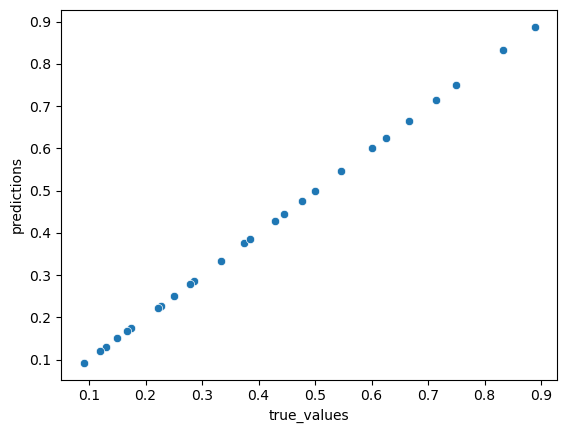

In [46]:
data = pd.DataFrame({'true_values': true_vals, 'predictions': predictions}).reset_index(drop=True)
sns.scatterplot(data=data, x = 'true_values', y = 'predictions')

<Axes: xlabel='true_values', ylabel='predictions'>

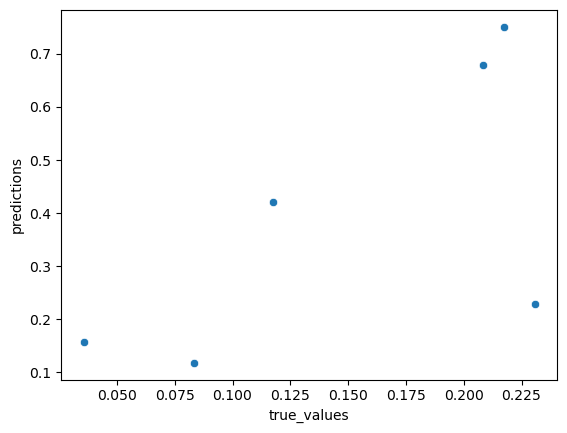

In [48]:
test_predictions = model.predict(pipeline.X_test)
test_data = pd.DataFrame({'true_values': pipeline.y_test, 'predictions': test_predictions}).reset_index(drop=True)
sns.scatterplot(data=test_data, x = 'true_values', y = 'predictions')